In [1]:
from pyaudi import gdual_double, gdual_vdouble
import pyaudi as pa 
import numpy as np
import chaospy as cp 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import seaborn
seaborn.set_style('whitegrid')

from Utils.boxgrid import boxgrid
import Utils.DA as da
from Utils.RK4 import RK4
# %matplotlib ipympl

# Tool dev

In [2]:
class Interval:
    def __init__(self, lower, upper):
        assert upper > lower
        self.interval = (lower, upper)
        self.midpoint = 0.5*(lower+upper)
        self.size = upper-lower
        
    def split(self):
        I1 = Interval(self.interval[0], self.midpoint)
        I2 = Interval(self.midpoint, self.interval[1])
        return I1,I2
    
    def __str__(self):
        return "I[{}, {}]".format(*self.interval)
    
    def contains(self, x):
        """ Vectorized method to check if an array of variables is in the interval"""
        x = np.asarray(x)
        return np.logical_and(x<=self.interval[1], x>=self.interval[0])
    
    def __contains__(self, x):
        """Allows use of 'value in Interval' syntax
        but only works for scalar x. Use the contains method
        for vectorized membership checking.
        """
        return x<=self.interval[1] and x>=self.interval[0]
    
# class History:
#     """ A collection of intervals """
#     def __init__(self)
#         self._history = []
#     def find(self, val):
        # """ Determines the interval in which value lies"""
    
def Construct(interval, nsubintervals):
    """ Decomposes an interval into n sub-intervals of equal length"""
    a,b = interval.interval
    ends = np.linspace(a,b,nsubintervals+1)
    return [Interval(a,b) for a,b in zip(ends, ends[1:])]

def find_nearest(array, values):
    """ Finds the deltas at which to evaluate the DAs, and
    returns a collection of indices referring to which results to keep
    Inputs: 
    array - array of evaluation points 
    values - array of expansion points [N_points, n_dims]
    """
    array = np.asarray(array)
    values = np.asarray(values)
    big_array = np.array([array-value for value in values]) # array of all possible deltas 
#     print(big_array)
#     print(np.linalg.norm(big_array, axis=2))
    if array.squeeze().ndim == 1:
        idx = np.abs(big_array).argmin(axis=0)
    else:
        idx = np.linalg.norm(big_array, axis=2).argmin(axis=0)
    midx = [(a,b) for a,b in zip(idx, range(len(idx)))]
    return [big_array[tup] for tup in midx], midx

# print(find_nearest(np.linspace(0,2,11),[0.33,0.66, 1, 1.33, 1.66]))


In [3]:
# 1-D Test
d,midx = find_nearest(np.linspace(0,2,3),[0.5,1.5])
print(d)

# Same thing with a useless second element 
evals = np.zeros((2,3))
evals[0,:] = np.linspace(0,2,3)
print(evals)

[-0.5, 0.5, 0.5]
[[0. 1. 2.]
 [0. 0. 0.]]


In [4]:
exp = [[0.5,0.2],[0.2,0.]]
ev = [[0.25,-0.1],[0.5,0.1]]
print(find_nearest(ev,exp))

([array([ 0.05, -0.1 ]), array([ 0. , -0.1])], [(1, 0), (0, 1)])


In [5]:
# Another 2-D Test
exp = [[0.25,0.25],[0.75,0.75]]
ev = [[0.25,0.3],[0.9,0],[0.6,0.4]]
print(find_nearest(ev,exp))

([array([0.  , 0.05]), array([ 0.65, -0.25]), array([0.35, 0.15])], [(0, 0), (0, 1), (0, 2)])


# Scalar test case 

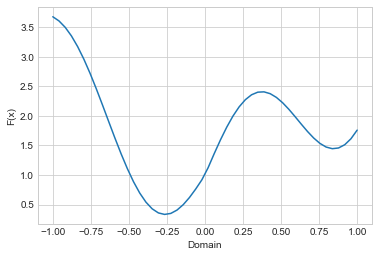

In [9]:
domain = (-1,1)
def fun(x):
    if isinstance(x, (gdual_double, gdual_vdouble)):
        return pa.sin(5*x) + pa.exp(pa.abs(x))
    else:
        return np.sin(5*x) + np.exp(np.abs(x))
x = np.linspace(*domain)
y = fun(x)
plt.figure(1)
plt.plot(x,y)
plt.xlabel('Domain')
plt.ylabel('F(x)')
plt.show()

Try single polynomials of different orders.

[-1, 1, -1, 4]

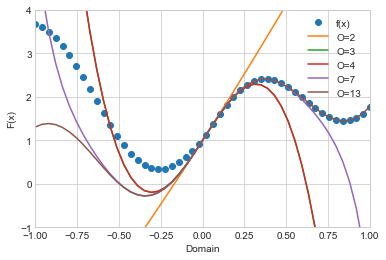

In [10]:
I = Interval(*domain)
plt.figure()
plt.plot(x,y,'o',label='f(x)')
plt.xlabel('Domain')
plt.ylabel('F(x)')
for order in [2,3,4,7,13]:
    xda = gdual_double(I.midpoint, 'x', order)
    yda = fun(xda)
#     print(yda)
    ye = da.evaluate([yda], 'x', x)
    plt.plot(x,ye,label='O={}'.format(order))
plt.legend()
plt.axis([-1,1,-1,4])

### Scalar test case - subdivide the domain and use low order polynomials
In general, the vectorized duals scale very favorably with more points. This means that we should favor more expansion points over higher order integrations. Thus a low order (2-5) expansion should be used with as many expansion points as needed to capture the reachable set with sufficient accuracy. However, this benefit may be hampered by the curse of dimensionality. In order to cover the n-dimensional volume a substantial number of points may be necessary. 

In [11]:
I0 = Construct(I,4)
expansion_points = [Ii.midpoint for Ii in I0]
deltas, keep = find_nearest(x, expansion_points)
xda = gdual_vdouble(expansion_points, 'x', 4)
yda = fun(xda)
ye = da.evaluate([yda], 'x', deltas).squeeze() # This is all expansion points evaluated at x points
sol = [ye.T[pair] for pair in keep]
y_expansion = yda.constant_cf


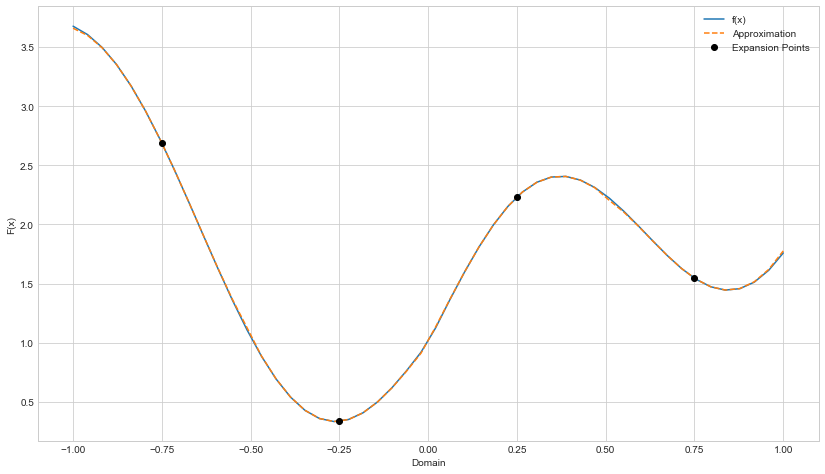

In [12]:
plt.figure(1, figsize=(14,8))
plt.plot(x,y,'-',label='f(x)')
plt.plot(x,sol,'--',label='Approximation')
plt.plot(expansion_points,y_expansion,'ko',label='Expansion Points')

plt.xlabel('Domain')
plt.ylabel('F(x)')

plt.legend()

A relatively low number of low order polynomials represents the nonlinear, non-differentiable function well.

# 2-D Case 

(2, 3600)


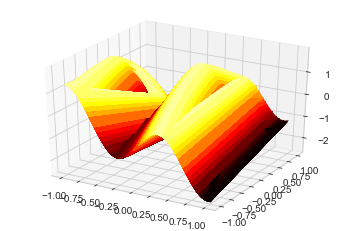

In [142]:
domain = [(-1,1)]*2
def fun(x):
    if isinstance(x[0], (gdual_double, gdual_vdouble)):
        return pa.sin(5*x[0]) + pa.cos(x[1] + x[0]**2)*pa.exp(-pa.abs(x[1])) + x[0]*x[1]**3 - x[1]**2
    else:
        return np.sin(5*x[0]) + np.cos(x[1] + x[0]**2)*np.exp(-np.abs(x[1])) + x[0]*x[1]**3 - x[1]**2
x = boxgrid(domain, 60, True).T
print(x.shape)
y = fun(x)

# plt.figure(figsize=(12,12))
# plt.scatter(x[0],x[1],c=y)
# plt.colorbar()
# plt.xlabel('Domain X')
# plt.ylabel('Domain Y')
X,Y = np.meshgrid(x[0],x[1])
Z = fun([X,Y])
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='hot')


In [143]:
order = 5
reduced_domain = [(-0.98,0.98)]*2
x_exp = boxgrid(reduced_domain, [12,8], True).T # One way to get expansion points. Can also use sobol or other LD sequences
# u1 = cp.Uniform(*domain[0])
# u2 = cp.Uniform(*domain[1])
# U = cp.J(u1,u2)
# x_exp = U.sample(64,'S')
print(x_exp.shape)
deltas, keep = find_nearest(x.T, x_exp.T)
print(np.array(deltas).shape)
xda = [gdual_vdouble(x_exp[0], 'x', order), gdual_vdouble(x_exp[1], 'y', order)]
yda = fun(xda)
ye = da.evaluate([yda], ['x','y'], deltas).squeeze() # This is all expansion points evaluated at x points
print(ye.shape)
sol = [ye.T[pair] for pair in keep]
print(np.shape(sol))
y_expansion = yda.constant_cf

(2, 96)
(3600, 2)
(3600, 96)
(3600,)


Peak error = 1.1e-05
Average error = 1.14e-06


Text(0.5,1,'Error Map\n |true-expansion|')

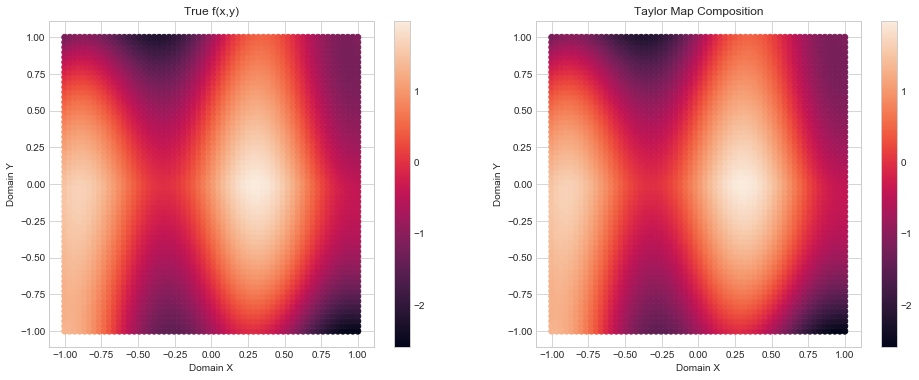

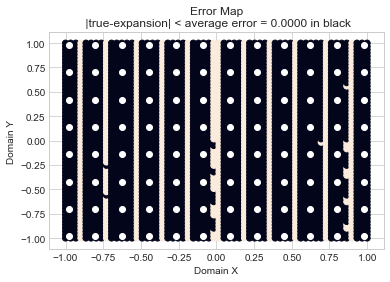

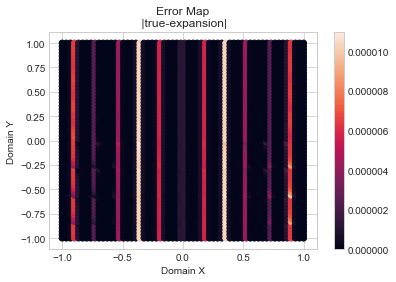

In [145]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.scatter(x[0],x[1],c=y)
plt.colorbar()
plt.xlabel('Domain X')
plt.ylabel('Domain Y')
plt.title('True f(x,y)')
plt.subplot(122)
plt.scatter(x[0],x[1],c=np.array(sol))
plt.title('Taylor Map Composition')
plt.colorbar()
plt.xlabel('Domain X')
plt.ylabel('Domain Y')

err = np.abs(np.array(sol)-y)
tol = np.mean(err)
print("Peak error = {:.3g}".format(err.max()))
print("Average error = {:.3g}".format(err.mean()))
plt.figure()
plt.scatter(x[0],x[1],c=err>tol)
plt.plot(x_exp[0], x_exp[1],'wo')
# plt.colorbar()
plt.xlabel('Domain X')
plt.ylabel('Domain Y')
plt.title('Error Map\n |true-expansion| < average error = {:.4f} in black'.format(tol))

plt.figure()
plt.scatter(x[0],x[1],c=err)
plt.colorbar()
plt.xlabel('Domain X')
plt.ylabel('Domain Y')
plt.title('Error Map\n |true-expansion|')

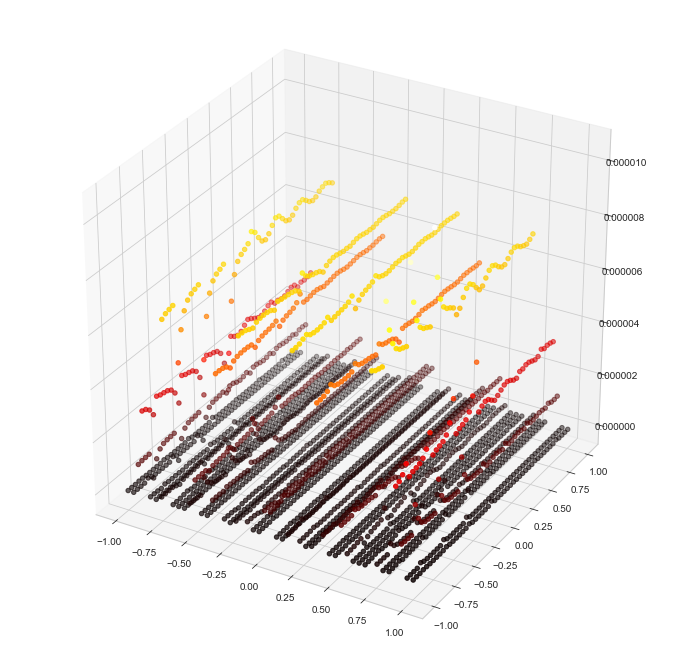

In [141]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
surf = ax.scatter(x[0],x[1],err,c=err, cmap='hot')

# Uncertain ODE Example
Start with a simple task. The ODE below describes a closed-loop double integrator with an uncertain drag-like term.
\begin{align}
\dot{x}_1 &= x_2 \\
\dot{x}_2 &= -ax_2^2 + u \\
\end{align}
where $a\in[0.5,3]$ and we arbitrarily close the loop $u = -kx_2$. The goal is to find the smallest value of $k$ such that $\mathbb{P}[x_1<2]>=\eta$ at a fixed time, 
i.e. a chance constrained problem. $\eta=1$ is equivalent to requiring that the entire distribution meets the constraint. The solution for $t_f=5$, $\eta=1$ is approximately $k=2.7$, while for $\eta=0.95$ $k=2.52$. Naturally, accepting more constraint violation allows for a lower gain to be used in this situation.

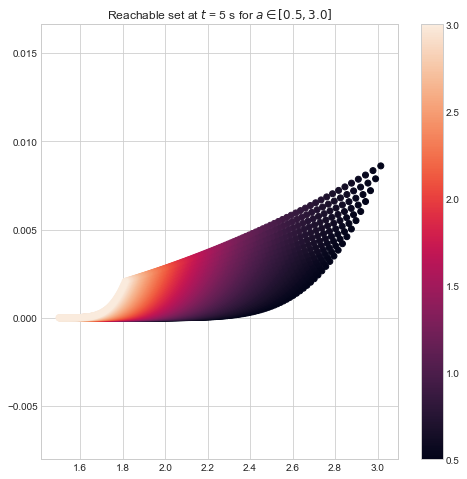

In [3]:
def dynamics(x, t, a, k):
    dx = np.zeros_like(x, dtype=type(a))
    dx[0] = x[1]
    dx[1] = -a*x[1]**2 - k*x[1]
    return dx 

tf = 5
t = np.linspace(0, tf, 100)
x0 = [1,3.5] 
AK = boxgrid([(0.5, 3),(1, 3)], 100, True).T
# a = np.linspace(0.5,3,200)
a,k = AK
# k = 2.52
X0 = [np.ones_like(a)*x0[0], np.ones_like(a)*x0[1]]
x = RK4(dynamics, X0, t, args=(a, k))
# print(x.shape)
# %matplotlib qt
plt.figure(figsize=(8,8))
# ax = plt.gca(projection='3d')
# print("Max value of x[0] = {} (constraint < 2)".format(x[-1, 0].max()))
# print("95%-ile of x[0] = {} (constraint < 2)".format(np.percentile(x[-1, 0],95)))

plt.title('Reachable set at $t$ = {} s for $a\in[{},{}]$'.format(tf,a[0],a[-1]))
plt.scatter(x[-1, 0], x[-1, 1], c=a)
plt.colorbar()

Learn the Taylor map from parameter values

In [5]:
ak_exp = boxgrid([(0.6, 2.9),(1.1, 2.9)], 10, True).T
a,k = da.make(ak_exp, ['a','k'], 3, array=True, vectorized=True)

X0 = [x0[0]*np.ones_like(ak_exp[0]),x0[1]*np.ones_like(ak_exp[0])]
# X0 = da.make(X0, ['x1','x2'], orders=0, array=True, vectorized=True) # May not need to do this
# print(X0)
X0 = x0
xda = RK4(dynamics, X0, t, args=(a, k))
xf = xda[-1]
print("Xf shape = {}".format(xf.shape))
deltas, keep = find_nearest(AK.T, ak_exp.T)
print(np.array(deltas).shape)
ye = da.evaluate(xf, ['a','k'], deltas) # This is all expansion points evaluated at x points
print(ye.shape)
# print(keep.shape)
sol = np.array([[ye[:,i].T[pair] for pair in keep] for i in range(2)])
# print(np.shape(sol))
# y_expansion = [da.const(xf[0]), da.const(xf[1])]
y_expansion = da.const(xf)
# print(y_expansion)

Xf shape = (2,)
(10000, 2)
(10000, 2, 100)


Text(0,0.5,'Reachable Y')

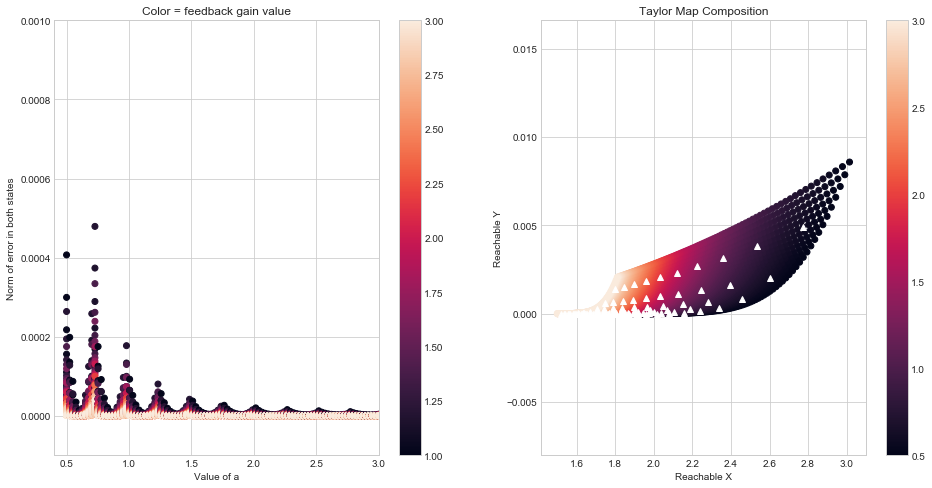

In [7]:
err = np.abs(x[-1]-sol)
errnorm = (err[0]**2 + err[1]**2)**0.5
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.scatter(AK[0], errnorm, c=AK[1])
plt.colorbar()
plt.xlabel('Value of a')
plt.ylabel('Norm of error in both states')
plt.title('Color = feedback gain value')
plt.axis([0.4, 3,-0.0001, 0.001])

# plt.figure(figsize=(12,12))
# plt.scatter(err[0], err[1], c=AK[0])
# plt.colorbar()
# plt.xlabel('Reachable X')
# plt.ylabel('Reachable Y')
# plt.title('Error')
# plt.axis('tight')

# plt.figure()
plt.subplot(122)

plt.scatter(sol[0],sol[1],c=AK[0])
plt.plot(y_expansion[0],y_expansion[1],'w^')
plt.title('Taylor Map Composition')
plt.colorbar()
plt.xlabel('Reachable X')
plt.ylabel('Reachable Y')